Stress the importance of noise
- gaussian noise
- uniform noise
- cauchy noise
- linear noise <br>
https://en.wikipedia.org/wiki/Noise_(signal_processing)

## Why noise in pattern recognition
By a simple defination, noise is the amount of meaningless information contained in corrupted data or noisy data. It incorporates any type of data that  a user system cannot understand or interpret correctly.
Noisy data is that data which is corrupted or distorded or having a very low Signal to noise ratio. Using improper procedures to getting rid of noise in the data can lead to inaccurate results and false conlusions. Noise reduction in noisy data is very important in order to  obtain accurate results. 

There are many different types of noise which includes: 
- gaussian noise
- uniform noise 
- cauchy noise

We are going to implement the gaussian type since it is normally distributed and hence easier to implement.

The gaussian distribution is given by:
$$
     \
X \sim \mathcal{N}(\mu,\,\sigma^{2})\, \mbox { where  $\mu$ is the mean and $\sigma^{2}$ the variance of the distribution.}\\
    \ 
$$
 


In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import scipy as scp
from copy import deepcopy
%matplotlib inline

In [2]:
# Parameters
L = 10  # Lenght of the edge of the image
N = L**2 # Number of spins 
p = 10 # Number of patterns
MF = 0 # Use or not the Mean Field strategy: if MF=1 uses MF, if MF = 0 only spins at
# a distance R interacts
R = 3 # The 3-nearest neighbor interacts
np.random.seed(1234) # Seed to make the random process reproducible


In [3]:
# Function that are in previous notebook
def random_patterns(N,p):
    xi = np.random.randint(0,2,N*p).reshape(p,N) # Each line is a pattern
    xi[xi==0]=-1
    return xi

def MF_coupling(xi,N):
    J = 1/N * np.array( [ (xi[:,i]*xi[:,j]).sum() for i in range(N) for j in range(N) ] )
    J = J.reshape(N,N)        
    for i in range(len(J)):
        J[i,i] = 0
    return J

def R_coupling(xi,N,R):
    J = MF_coupling(xi,N)
    for i in range( J.shape[0] ):
        J_temp = J[i].reshape(L,L)
        for j in range(L):
            y = (i%L -j)**2 # Look at indexes should be ok -1
            for k in range(L):
                if np.sqrt( (i//L - k)**2 + y ) > R: J_temp[j,k] = 0
        J[i] = J_temp.reshape(1,N)
    return J

def update(sys1):
    sys = deepcopy(sys1)
    N = len(sys)
    for i in range(N):
        temp = 0
        for j in range(N): #Maybe it is possible to set the cycle on J[i][j]!=0 only
            temp +=  J[i][j]*sys[j] 
        sys[i] = np.sign(temp)
    return np.sign(sys)

def deterministic_hopfield(sys1, t):
    sys = deepcopy(sys1)
    for i in range(t):
        sys = update(sys)
    return sys

def error_im(xi_idx, sys):
    wrong_pixels = (np.abs( sys-xi_idx )/2).sum()
    return wrong_pixels/len(sys)

def assign_pattern(xi,sys):
    errors = [ error_im(i,sys) for i in xi ]
    correct = np.argmin(errors)
    return correct

def total_error(xi,t):
    errors = []
    prediction = []
    for mu in range(len(xi)):
        sys = deterministic_hopfield(xi[mu],t)
        errors.append( error_im(xi[mu],sys) )
        if assign_pattern(xi,sys)==mu:
            prediction.append( 1 )
        else: prediction.append( 0 )
    errors = (np.array(errors)).mean()
    prediction = np.array(prediction).sum()/len(xi)
    return errors, prediction


Original pattern


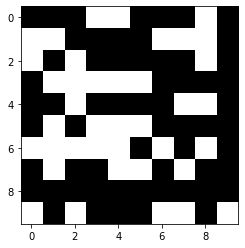

In [4]:
xi = random_patterns(N,p)
idx = np.random.randint(0,p)
J = R_coupling(xi,N,R)
#J = MF_coupling(xi,N)
print('Original pattern')
plt.imshow(xi[idx].reshape(L,L),cmap='Greys')

The error of the algorithm is 0.040000
The algorithm recognised the pattern 1 and the correct pattern is 1


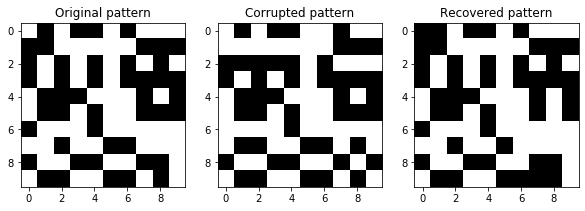

In [5]:
#creating corrupted random data thus corrupting xi
def corrupt_uniform(sys, q): # q probability to flip the pixel
    sys_temp = deepcopy(sys)
    N = sys.shape[0]
    for i in range(N):
        r = np.random.rand()
        if r < q:
            sys_temp[i] *= -1
    return sys_temp
    
idx = 1
yi = corrupt_uniform(xi[idx],0.1)
sys = deterministic_hopfield(yi,30)

wrong_pixels = error_im(xi[idx],sys)
assigned_pattern = assign_pattern(xi,sys)


fig, ax = plt.subplots(1,3, figsize=(10,6))
ax[0].set_title('Original pattern')
ax[0].imshow(xi[idx].reshape(L,L),cmap='Greys')
ax[1].set_title('Corrupted pattern')
ax[1].imshow(yi.reshape(L,L),cmap='Greys')
ax[2].set_title('Recovered pattern')
ax[2].imshow(sys.reshape(L,L),cmap='Greys')
print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,idx))

In [6]:
#def corrupt_norm():
    # overlap a 2-d gaussian to the image. How does the recognition change with regard
    # the position of the centroid?

SyntaxError: unexpected EOF while parsing (<ipython-input-6-945c56196853>, line 3)

In [ ]:
#def corrupt_cauchy():

In [7]:
probabilities = np.arange(0,1,0.005)
error = []

for q in probabilities:
    idx = 5
    yi = corrupt_uniform(xi[idx],q)
    sys = deterministic_hopfield(yi,30)

    wrong_pixels = error_im(xi[idx],sys)
    assigned_pattern = assign_pattern(xi,sys)
    error.append(wrong_pixels)

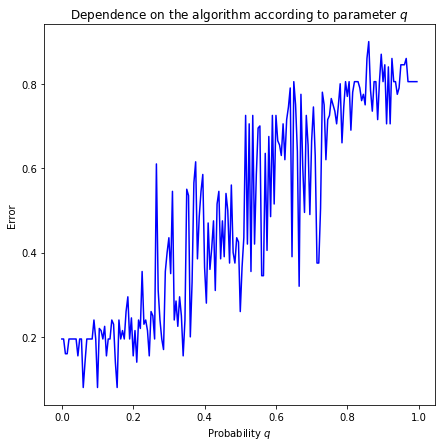

In [8]:
#plot the results
fig, ax1 = plt.subplots(figsize=(7, 7))

ax1.plot(probabilities, error, 'b')
ax1.set_title('Dependence on the algorithm according to parameter $q$')
ax1.set_xlabel('Probability $q$')
ax1.set_ylabel('Error');

There is a tendence but the algorithm fluctuates too much.  The tendence is something that we expected, when we make small changes into the original image the error is too small but if we makes changes 